created by Ignacio Oguiza - email: oguiza@gmail.com

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [3]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

# The importance of scaling in Time Series: LSST 💫

Scaling refers to how we prepare the data so that the network can really leverage all the information it contains. 
All network contain some parameters that will be shared across samples. If we are not careful when scaling our data some samples or some features will have a much larger impact that others, not because of their importance, but because of their scale.
We want to provide all samples and all features the possibility to contribute to training the network correcly.

In this notebook, we'll use a UCR multivariate dataset: LSST. This is a subset from a Kaggle competition held last year.
The current state of the art accuracy for this dataset is 57.5% using a nearest neighbor based on dynamic time warping distance).
We'll try to beat that state of the art just using the basic train process with a good scaling. Nothing else.

☣️ It's important to highlight though that here we are training a network from scratch, not using transfer learning. With transfer learning you should use the same scaling that was used to train the model you are using.

## Import libraries 📚

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai_timeseries import *
from torchtimeseries.models import *

## Prepare data 🔢

In [6]:
dsid = 'LSST'
bs = 128

In [7]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, verbose=True)
X_test, y_test = None, None

Dataset: LSST
Download and decompressing data...
Successfully extracted file /tmp/tmp9wctgzey/LSST.zip to path data/UCR/LSST
...data downloaded and decompressed
Extracting data...
...extraction complete
Successfully extracted dataset
X_train: (2459, 6, 36)
y_train: (2459,)
X_valid: (2466, 6, 36)
y_valid: (2466,) 



First we'll check that this dataset has not been previously scaled

In [8]:
print('mean:', X_train.mean(), ' std:', X_train.std(), ' min:', X_train.min(), ' max:', X_train.max())

mean: 33.53173110073538  std: 929.5484599126105  min: -40036.0  max: 64062.0


It's obvious there was no previous scaling, so we need to decide how we want to scale data.
I've built some functionality that allow us to do this very easily using fastai.

There are 2 main types of scaling: 

- standardize: where you process your data to get to a mean of 0 and standard deviation of 1
- normalize: where you process your data to be within a range (usually -1, 1)

Each of these 2 types have 3 subtypes: 

- all samples: where you extract the statistics that you will then apply from all train samples at the same time (1 mean and 1 std or 1 min and 1 max). You then apply these stats to all samples (train, valid and test).
- (all samples) per channel: where you extract the statistics that you will then apply from each channel of all train samples (1 mean and 1 std or 1 min and 1 max per channel). You then apply these stats to all samples (train, valid and test).
- per sample: here you just calculate the stats for each individual sample, and then process each sample individually.

It's difficult to know in advance which one these options may work better. But there are a few guidelines: 👀
- It's always important to scale your data in order to get better performance.
- If you use all samples or per channel, you need to take into account the presence of outliers, as they may have a huge impact on the rest of samples. For this reason you should avoid using normalize with all samples, or per_channel. Just 1 outlier may spoild the result. (One option may also be to manage the outlier, either capping it or eliminating it, but that is outside the scope of this notebook).
- For univariate time series, all samples and (all samples) per channel will provide the same result. These 2 are different in the case of multivariate time series. 
- If you use all samples or per sample, you will maintain the ratio between different channels. If that is important in your problem, you shouldn't break that relationship, and thus you should avoid using per_channel.
- In general, if you can it's good to test at least an option including standardize and another including normalize. 
- To quickly test these options, you may just use partial data, so that the test runs quickly.

In [7]:
# Scaling
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1) 

In [8]:
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data

TSDataBunch;

Train: LabelList (2459 items)
x: TSList
TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36)
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (2466 items)
x: TSList
TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36),TimeSeries(ch=6, seq_len=36)
y: CategoryList
0,0,0,0,0
Path: .;

Test: None

## LSST Experiments  🧪

### No normalization  ⛔️

This is something you should always avoid. Performance will usually be pretty erratic. You can see the wide variations in y-axis in the TS images below.

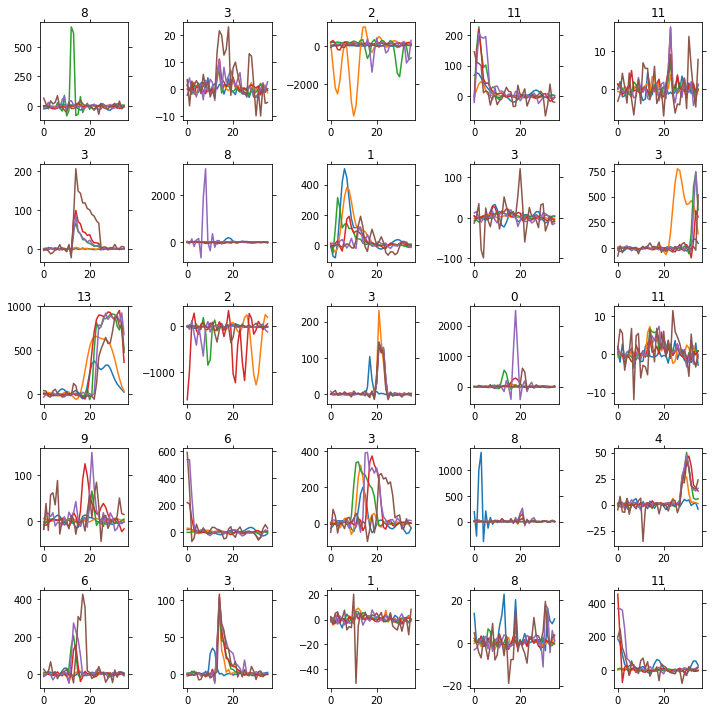

In [148]:
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.446707,2.422452,0.348337,00:05
1,2.263125,2.100761,0.386861,00:00
2,2.072159,1.934413,0.406732,00:00
3,1.895466,1.867415,0.450527,00:00
4,1.746551,1.585314,0.493106,00:00
5,1.619522,1.900705,0.500811,00:00
6,1.514771,1.686240,0.504866,00:00
7,1.444978,1.483901,0.517843,00:00
8,1.381523,2.146180,0.364152,00:01
9,1.336359,1.474938,0.535685,00:01


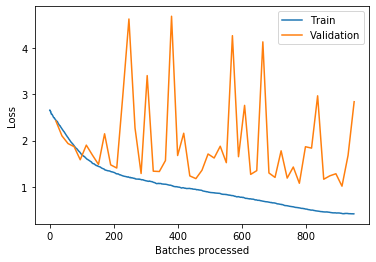

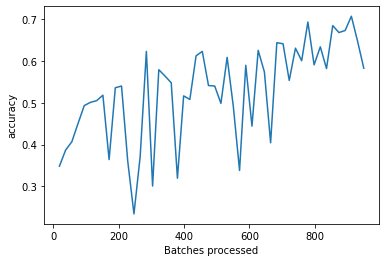

In [17]:
# no normalization
model = ResNet(data.features, data.c).to(device)
learn = Learner(data, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

As you can see, this result is better than the current state of the art, but it's very unstable. The last part of the accuracy chart has huge variations, so if we repeated this test multiple times, we'd get very different results.

### Standardize all samples

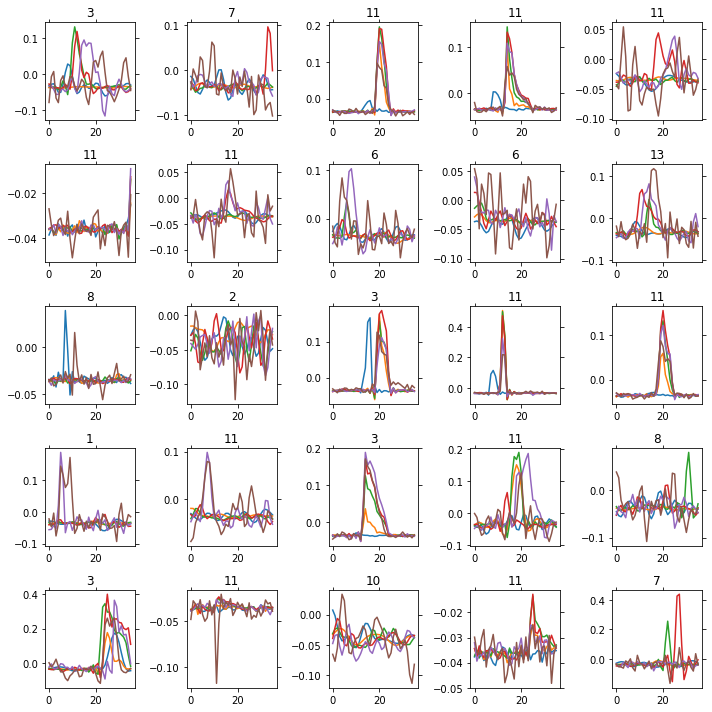

In [9]:
scale_type = 'standardize'
scale_by_channel = False
scale_by_sample  = False 
scale_range = (-1, 1) 
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.487058,2.493620,0.362936,00:01
1,2.317643,2.180861,0.378345,00:01
2,2.125309,1.950161,0.408354,00:01
3,1.922684,1.644788,0.498378,00:01
4,1.753308,2.039003,0.480535,00:01
5,1.622316,1.687091,0.464720,00:01
6,1.529946,2.488882,0.398621,00:01
7,1.462161,1.594398,0.510543,00:01
8,1.404065,1.579774,0.500000,00:01
9,1.353404,5.517760,0.161395,00:01


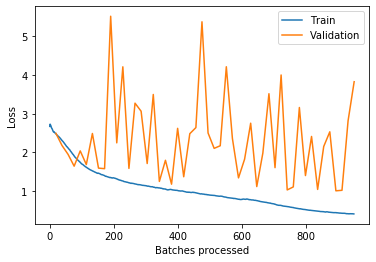

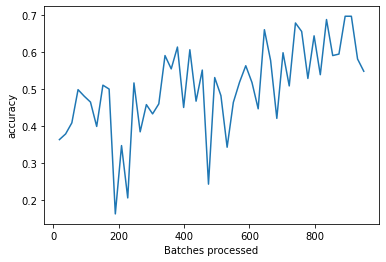

In [65]:
# std all samples
model = ResNet(data.features, data.c).to(device)
learn = Learner(data, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

### Standardize per channel

This scaling is widely used in computer vision. 

However, with time series data you have a risk you need to evaluate. If you apply any stats to each channel, you will break the ratio between channels. This may or may not be important in your case.

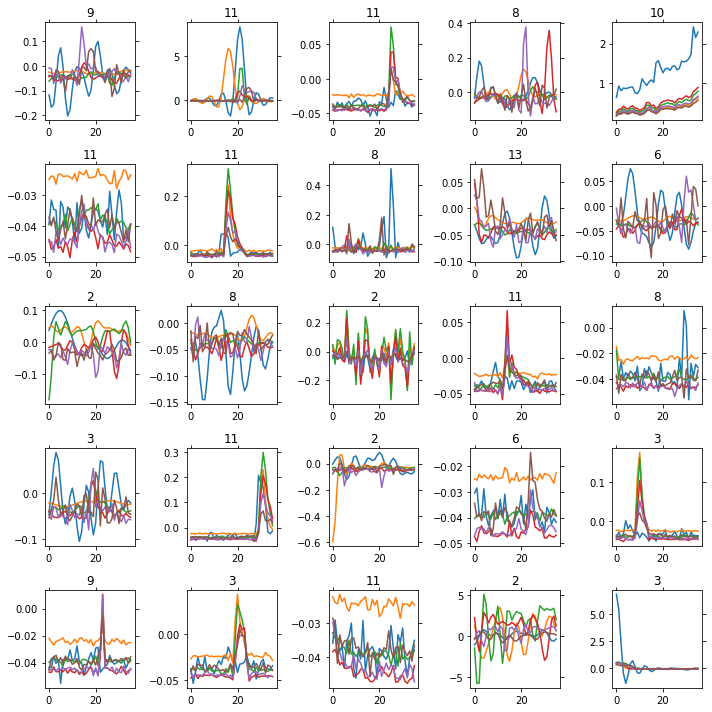

In [10]:
scale_type = 'standardize'
scale_by_channel = True
scale_by_sample  = False 
scale_range = (-1, 1) 
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.435665,2.474323,0.356853,00:01
1,2.273937,2.247411,0.399838,00:01
2,2.091973,1.950516,0.421736,00:01
3,1.913424,1.758251,0.447689,00:01
4,1.771572,1.601308,0.481752,00:01
5,1.660304,1.719367,0.414842,00:01
6,1.561249,1.870712,0.496756,00:01
7,1.483750,1.408243,0.514193,00:01
8,1.410957,1.403134,0.561233,00:01
9,1.349937,1.619788,0.524736,00:01


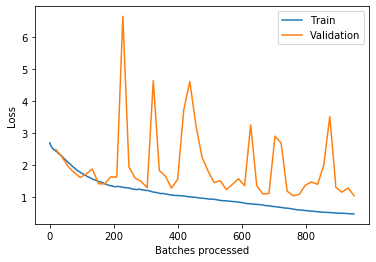

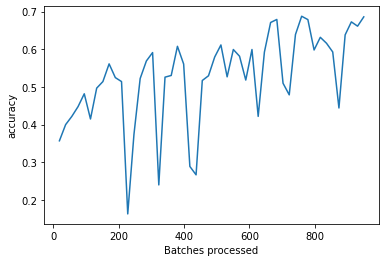

In [68]:
# std per channel
model = ResNet(db.features, db.c).to(device)
learn = Learner(db, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

### Standardize per sample

This preserves the relationship between channels, which may be important for multichannel time series, specially if data for all channels comes from the same instrument. For example, light intensity in a telescope. 

Sometimes, data comes from different instruments. In this scenario, all samples or per channel may be a better option that per sample.

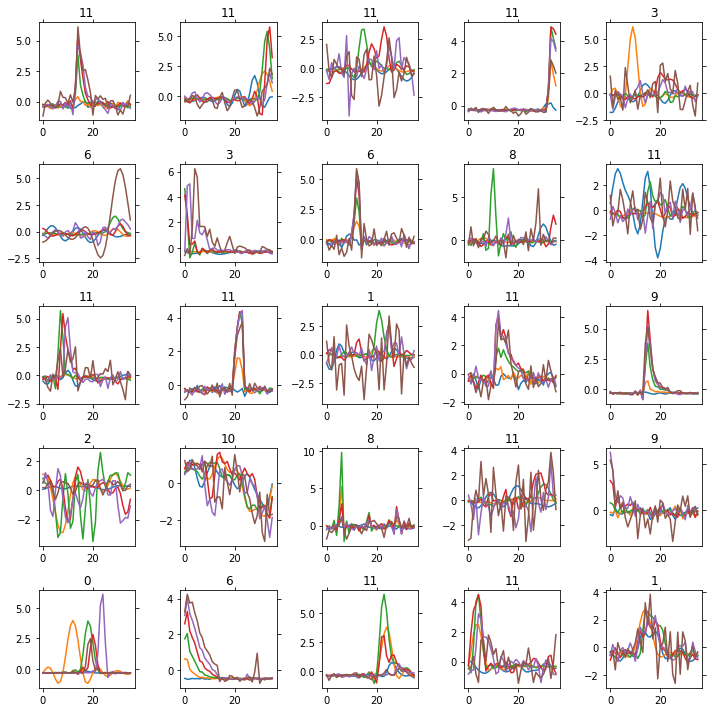

In [11]:
scale_type = 'standardize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1) 
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.140415,2.328148,0.364964,00:01
1,1.772752,1.437965,0.593268,00:01
2,1.522902,1.176072,0.635442,00:01
3,1.333876,1.097199,0.648418,00:01
4,1.185824,1.061710,0.660178,00:01
5,1.064515,1.329286,0.638686,00:01
6,0.970020,1.346631,0.597324,00:01
7,0.891030,1.884272,0.480535,00:01
8,0.845822,1.873089,0.568938,00:01
9,0.802442,1.929420,0.414842,00:01


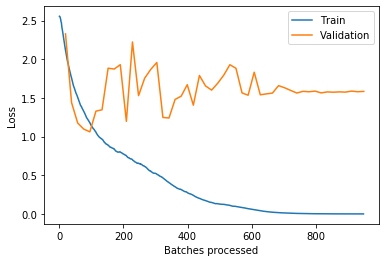

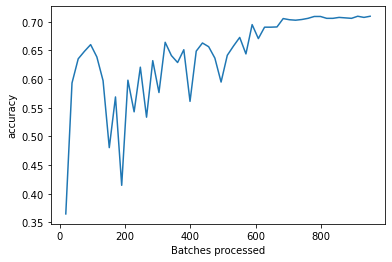

In [73]:
# std per sample
model = ResNet(db.features, db.c).to(device)
learn = Learner(db, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

This result is much more stable that the previous ones we have seen.

### Normalize all samples

Here you'll see the problem with outliers (that may very well be valid, but make the scale of other samples really small).

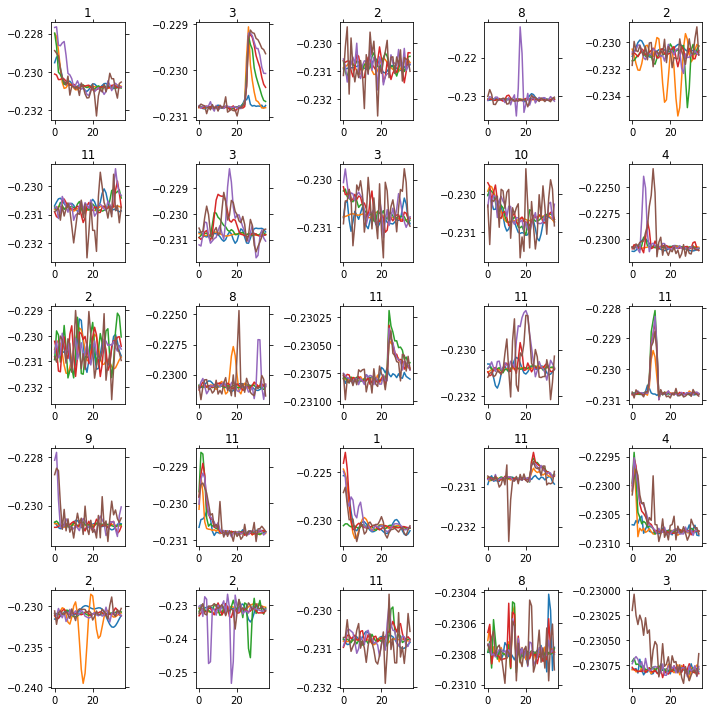

In [12]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = False 
scale_range = (-1, 1) 
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.459810,2.504283,0.315085,00:01
1,2.262718,2.315248,0.316707,00:01
2,2.103029,2.613676,0.122871,00:01
3,1.958409,7.166973,0.117194,00:01
4,1.825066,2.289252,0.384834,00:01
5,1.730058,4.208426,0.134631,00:01
6,1.647212,2.389389,0.133009,00:01
7,1.571170,6.340352,0.078264,00:01
8,1.513629,2.558434,0.035685,00:01
9,1.483970,2.649939,0.042985,00:01


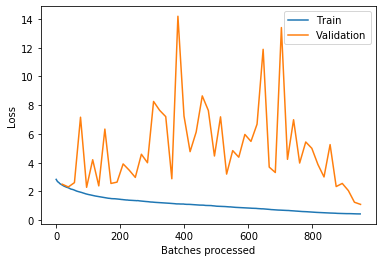

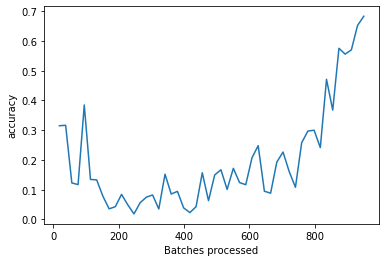

In [80]:
# norm all samples
model = ResNet(db.features, db.c).to(device)
learn = Learner(db, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

### Normalize per channel

As you can see, the charts here also look very different, and again, this may be due to outliers in the dataset.

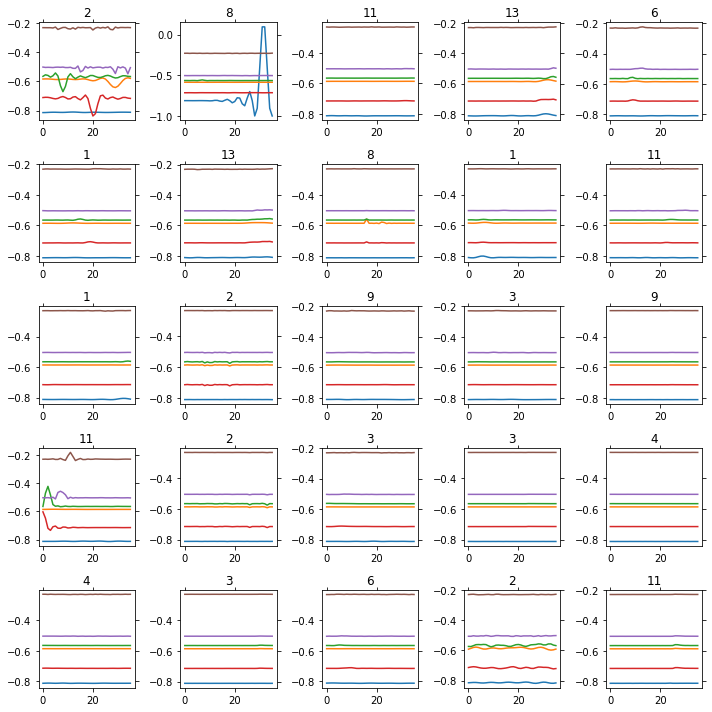

In [13]:
scale_type = 'normalize'
scale_by_channel = True
scale_by_sample  = False 
scale_range = (-1, 1) 
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.373607,2.446362,0.315491,00:01
1,2.185550,2.181334,0.321168,00:01
2,2.040458,2.349421,0.169911,00:01
3,1.911824,1.977674,0.392944,00:01
4,1.799185,2.207562,0.180454,00:01
5,1.698656,3.168952,0.146796,00:01
6,1.620245,4.118021,0.105028,00:01
7,1.550609,3.357793,0.077048,00:01
8,1.500897,2.789325,0.160584,00:01
9,1.445959,3.808056,0.088808,00:01


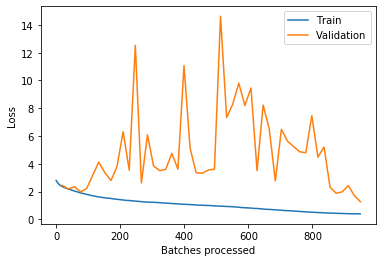

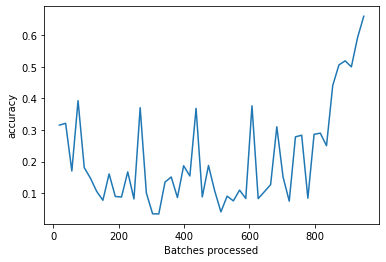

In [85]:
# norm per channel
model = ResNet(db.features, db.c).to(device)
learn = Learner(db, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

### Normalize per sample

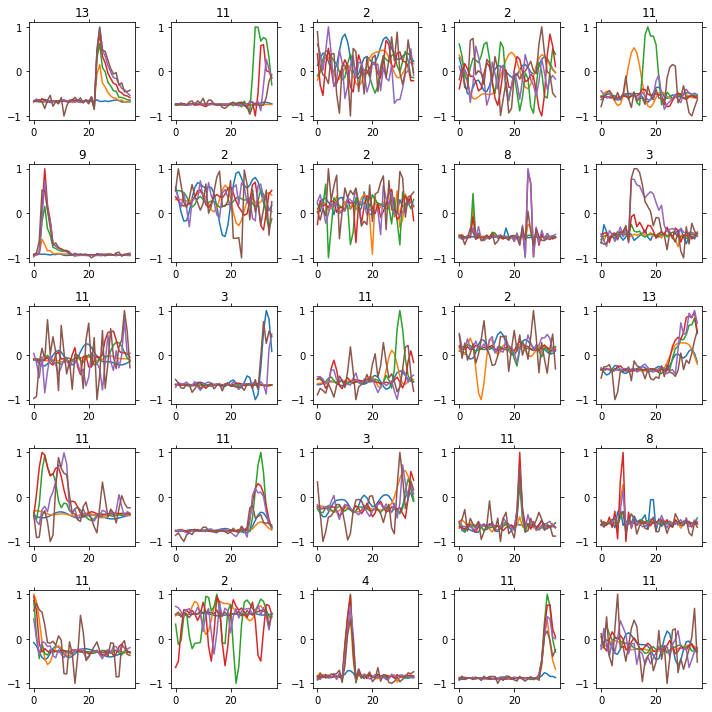

In [14]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1) 
data = (ItemLists('.', TSList(X_train),TSList(X_valid))
        .label_from_lists(y_train, y_valid)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,2.179944,2.364137,0.276561,00:01
1,1.881266,1.640496,0.514193,00:01
2,1.663221,1.347429,0.571776,00:01
3,1.490394,1.363746,0.559611,00:01
4,1.344385,1.158531,0.645174,00:01
5,1.222168,1.163707,0.620438,00:01
6,1.135267,2.205502,0.409976,00:01
7,1.062271,1.261159,0.603406,00:01
8,1.004631,1.891703,0.464720,00:01
9,0.955446,1.427532,0.572993,00:01


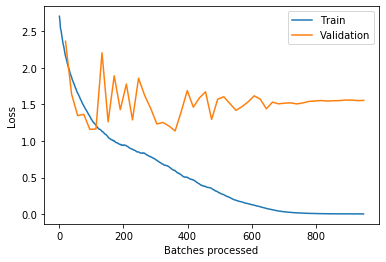

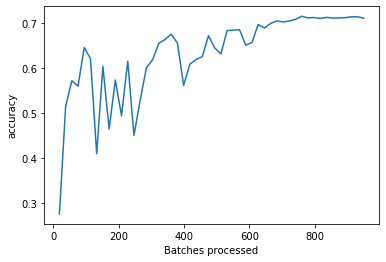

In [90]:
# norm per sample
model = ResNet(db.features, db.c).to(device)
learn = Learner(db, model,metrics=accuracy)
learn.fit_one_cycle(50)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

## Conclusions

We have reviewed how scaling can have a significant impact when training a neural network. There are several options to scale time series data, and it's important to evaluate pros and cons of each option. In any case, it's good to test the impact (even if just on a small data subset) so that you allow the network to converge to a good performance.

In the particular case of LSST, it seems that it's importance to preserve the relation between the different the different channels (This is irrelevant in the case of univariate time series, but something to take into account when dealing with multivariate datasets). Both standardize per sample and normalize per sample turned out to work very well. The rest were really very unstable, a clear sign the model is not properly trained.

Scaling is so important, that we have achieved a new state of the art result with this simple trick!

<img src="images/LSST_scalling.jpg">